## Importing libraries, parameters.py

In [1]:
"""Create parameters.py and load it"""

# Directory for .inp file:
path = 'INP file examples\\chem_Otomo2018_without_O.inp'

# import libraries:
import importlib   # For reloading your own files
from termcolor import colored   # for colored error messages
# my own files:
try:
    import inp_data_extractor as inp
except:
    try:
        import Bubble_dynamics_simulation.inp_data_extractor as inp
    except:
        print(colored(f'Error, \'inp_data_extractor.py\' not found', 'red'))
importlib.reload(inp)   # reload changes you made
inp.extract(path)

import parameters as par   # numeric constants and coefficents
importlib.reload(par)   # reload changes you made
print(par.model)

path=INP file examples\chem_Otomo2018_without_O.inp
Note, lambda value for specie 'H' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH2' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N' is not in data.py: 0.0 is used
Note, lambda value for specie 'NNH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H4' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H3' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H2' is not in data.py: 0.0 is used
Note, lambda value for specie 'H2NN' is not in data.py: 0.0 is used
Warning, third body 'H2O' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
Warning, third body 'AR' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
model: chem_Otomo2018_without_O
File 'parameters.py' succesfully created
chem_Otomo2018_without_O


In [2]:
"""Libraries"""

# for plotting:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

import numpy as np   # matrices, math
import time   # runtime measurement
import os    # file management
import pandas as pd   # data frames
from multiprocessing import Pool, cpu_count   # multithreading
import importlib   # reload changes you made

# my own file:
already_imported = 'gd' in globals()
try:
    import gradient_descent as gd
except:
    try:
        import Bubble_dynamics_simulation.gradient_descent as gd
    except:
        print(colored(f'Error, \'gradient_descent.py\' not found', 'red'))
if already_imported: importlib.reload(gd)   # reload changes you made

model: chem_Otomo2018_without_O
target specie: NH3
excitation: no_excitation (control parameters: [])
enable heat transfer: True	enable evaporation: False	enable reactions: True	enable dissipated energy: False


## Ranges, settings

In [3]:
# Control parameter ranges
# make sure, it's only 2D

ranges = dict(
  # Initial conditions:
    # bubble equilibrium radius [m]
    R_E = [1.0e-6*x for x in [1.0, 10.0]], # [um --> m]
    # initial radius / equilibrium radius R_0/R_E [-]
    ratio = [1.0, 10.0],
    # indexes of species in initial bubble
    gases=[[par.index['N2'], par.index['H2']]],
    # Molar fractions of species in the initial bubble (H2 and N2) [-]
    fractions=[[0.25, 0.75]],
  # Ambient parameters:
    # ambient pressure [Pa]
    P_amb = [x * par.atm2Pa for x in [10.0]], # [atm --> Pa]
    # ambient temperature [K]       
    T_inf = [par.absolute_zero + x for x in [30.0]], # [°C --> K]
  # Liquid parameters:
    # water accommodation coefficient [-]
    alfa_M = [0.05],
    #P_v = par.P_v,                    # vapour pressure [Pa]
    #mu_L = par.mu_L,                  # dynamic viscosity [Pa*s]
    # sound speed [m/s]
    c_L = [par.c_L],
    # surfactant (surface tension modfier) [-]
    surfactant = [1.0],
  # Excitation parameters: (excitation_type = no_excitation)
    # -
)

for key in gd.de.excitation_args:
    if key not in ranges:
        print(colored(f'Error, {key} not in ranges', 'red'))

examined_keys = []
for key in ranges:
    if len(ranges[key]) > 1:
        examined_keys.append(key)

print(f'The following control parameters will be examined: {examined_keys}')
if len(examined_keys) != 2:
    print(colored(f'Error, exactly 2 control parameters have to be examined', 'red'))
key1 = examined_keys[0]
key2 = examined_keys[1]

The following control parameters will be examined: ['R_E', 'ratio']


In [4]:
# Settings:
to_optimize = 'energy_efficiency'   # key in data from de.get_data()
directory = 'D:\\parameter_studies\\Ammonia_noexc_2D'
file_base_name = 'output_'

## Reading files, 2D contour plot

In [51]:
# create a dataframe
all_data = pd.DataFrame()
num = 0

# iterate trough all files in directory (including subdirectories)
for (root, dirs, files) in os.walk(directory):
    for file in files:
        # ignore python rubish
        if 'ipynb_checkpoints' in root:
            continue
        # check if it's a CSV starting with file_base_name
        if file[-4:] != '.csv':
            continue
        if file[:len(file_base_name)] != file_base_name:
            continue

        # read file
        num += 1
        current_data = pd.read_csv(os.path.join(root, file))
        print(f'\t{file: <24} ({current_data.shape[0]: >4} rows)')
        all_data = pd.concat([all_data, current_data])

# locate successful simulations
good_data = all_data.loc[
    (all_data['error_code'] % 100 <= 3) & ((all_data['error_code'] // 100) % 10 != 1) &
    (all_data['energy_efficiency'] > 0.0) & (all_data['energy_efficiency'] == all_data['energy_efficiency']) # positive not NaN
]
good_data['output_list'] = np.log10(good_data['energy_efficiency'])
good_data = good_data.sort_values(['ID'], ascending=True)
print(f'Good data: {good_data.shape[0]} rows ({100*good_data.shape[0]/all_data.shape[0]: .2f} %)')

	output_1.csv             (2500 rows)
Good data: 2433 rows ( 97.32 %)


C:\Users\aron\AppData\Local\Temp\ipykernel_15240\3364245952.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_data['output_list'] = np.log10(good_data['energy_efficiency'])


In [52]:
# Check ranges vs good_data:
for key in ranges:
    llist = good_data[key].unique()
    llist.sort()
    if len(llist) > 1 and len(ranges[key]) < 2:
        print(colored(f'Error, {key} has {len(llist)} distinct values, but it should be constant {ranges[key][0]}', 'red'))
    if len(ranges[key]) > 1:
        if len(llist) < 2:
            print(colored(f'Error, {key} should have  values between {ranges[key][0]} and {ranges[key][1]}', 'red'))
        if abs(llist[0] - ranges[key][0]) > 1e-3 * ranges[key][0] + 1e-8:
            print(colored(f'Error, {key} has values between {llist[0]} and {llist[-1]}, but it should be between {ranges[key][0]} and {ranges[key][1]}', 'red'))
        if abs(llist[-1] - ranges[key][1]) > 1e-3 * ranges[key][1] + 1e-8:
            print(colored(f'Error, {key} has values between {llist[0]} and {llist[-1]}, but it should be between {ranges[key][0]} and {ranges[key][1]}', 'red'))

In [53]:
# list unique values:

output_list = list(good_data[to_optimize])
list1 = list(good_data[key1])
list2 = list(good_data[key2])
value_list1 = good_data[key1].unique()
value_list2 = good_data[key2].unique()
value_list1.sort()
value_list2.sort()
print(f'{key1}: from {value_list1[0]} to {value_list1[-1]} ({len(value_list1)} values)')
print(f'{key2}: from {value_list2[0]} to {value_list2[-1]} ({len(value_list2)} values)')

R_E: from 1e-06 to 1e-05 (50 values)
ratio: from 1.0 to 10.0 (50 values)


In [54]:
# Interpolate missing values:

vmin = min(output_list)
vmax = 100.0*vmin
combined = [(x, y) for x, y in zip(list1, list2)]
X, Y = np.meshgrid(value_list1, value_list2)
Z = np.zeros(X.shape)

for i, x in enumerate(value_list1):
    for j, y in enumerate(value_list2):
        if (x, y) in combined:
            index = combined.index((x, y))
            if (output_list[index-1] < vmax and 100*vmin < output_list[index] and 
                j != 0 and j != len(value_list2)-1 and
                output_list[index] > 10*output_list[index+1] and
                output_list[index] > 10*output_list[index-1]):

                output_list[index] = (output_list[index-1] + output_list[index+1]) / 2
                print(f'{index}: R_E={1e6*x : .2f}, ratio={y: .2f}, output={output_list[index]: .3f}')
            if (j == 0 or j == len(value_list2)-1) and (i != 0 and i != len(value_list1)-1 and i != len(value_list1)-2):
                if (output_list[index] > 10*output_list[index+len(value_list2)] and
                    output_list[index] > 10*output_list[index-len(value_list2)]):

                    output_list[index] = (output_list[index-len(value_list2)] + output_list[index+len(value_list2)]) / 2
                    print(f'{index}: R_E={1e6*x : .2f}, ratio={y: .2f}, output={output_list[index]: .3f}')
            Z[j, i] = output_list[index]
        else:
            index = i * len(value_list2) + j
            extrapolation = (output_list[index-1] + output_list[index]) / 2
            combined = combined[:index] + [(x, y)] + combined[index:]
            output_list = output_list[:index] + [extrapolation] + output_list[index:]
            Z[j, i] = output_list[index]
            pass

if True:
    Z = np.log10(Z)
    vmin = np.log10(vmin)
    vmax = 2.0*vmin

134: R_E= 1.37, ratio= 7.24, output= 1070640.217
578: R_E= 3.02, ratio= 6.14, output= 531759.877


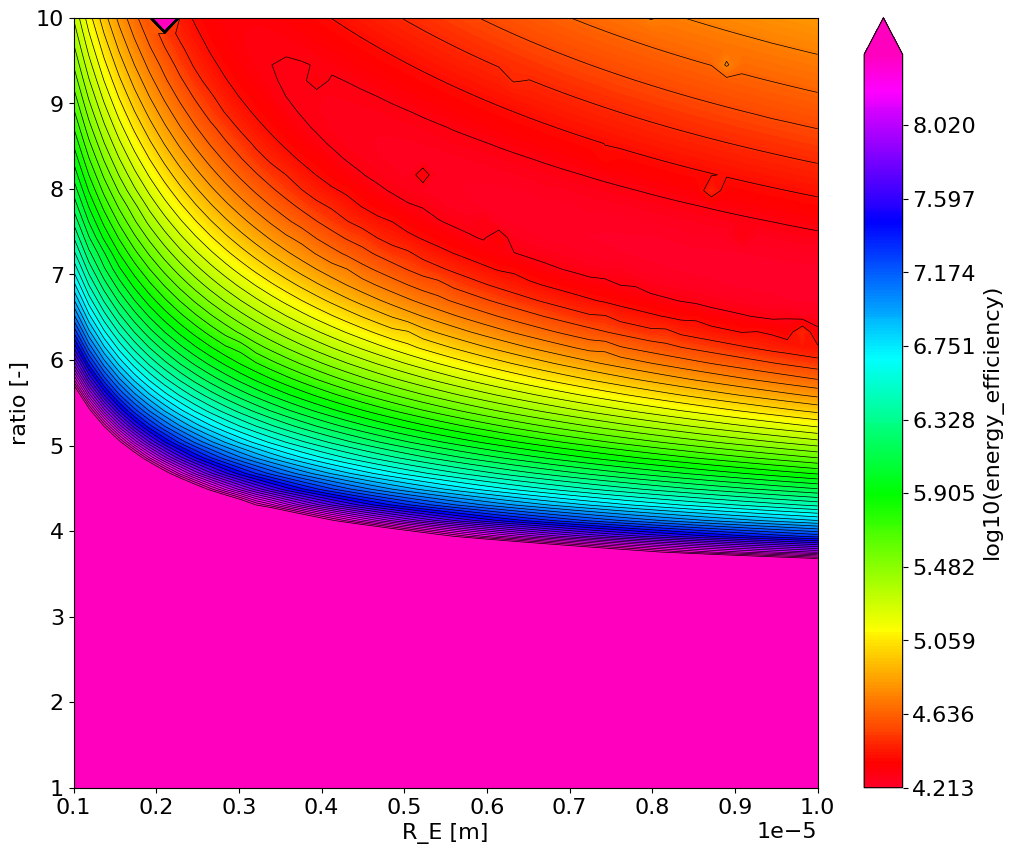

In [55]:
# Plot:

fig,ax=plt.subplots(1, 1, figsize=(12, 10))
levels = np.linspace(vmin, vmax, 250)
cp = ax.contourf(X, Y, Z, levels=levels, cmap='gist_rainbow', vmax=vmax, extend='max')
ax.contour(X, Y, Z, levels=np.linspace(vmin, vmax, 50), colors='black', linewidths=0.5)
fig.colorbar(cp, label='log10(energy_efficiency)') # Add a colorbar to a plot
#ax.set_title('log10(energy_efficiency)')
ax.set_xlabel('R_E [m]')
ax.set_ylabel('ratio [-]')
plt.show()

## Plot gradient descent search

In [32]:
start_point = gd.rand_point(ranges, padding=0.1)   # random point in ranges
print(f'Starting point: ({key1}={start_point[key1]}, {key2}={start_point[key2]})')

Starting point: (R_E=2.666553426105659e-06, ratio=4.014389887369118)


In [33]:
start_point_copy = gd.de.copy(start_point)
datas, last_bests, elapsed_time = gd.gradient_descent(
    ranges, to_optimize, start_point_copy,
    step_limit=100, max_step_until_decay=10, first_step=0.1, decay=0.5, min_step=1e-4, delta=1e-6,
    verbose=True, log10=False,
    t_int=np.array([0.0, 1.0]), LSODA_timeout=30, Radau_timeout=300
)

0. step; last_best= 5.246e+10; absolute_best= 5.246e+10; step_size= 0.1000
	point   =(R_E= 2.666553e-06; ratio= 4.014390e+00; )
	output  =13226642.136248939; success=True
	gradient=(R_E=-5.089916e-01; ratio=-8.607715e-01; )
	change  =(R_E= 4.580924e-07; ratio= 7.746944e-01; )
1. step; last_best= 1.323e+07; absolute_best= 1.323e+07; step_size= 0.1000
	point   =(R_E= 3.124646e-06; ratio= 4.789084e+00; )
	output  =908707.104062871; success=True
	gradient=(R_E=-3.000035e-01; ratio=-9.539381e-01; )
	change  =(R_E= 2.700032e-07; ratio= 8.585443e-01; )
2. step; last_best= 9.087e+05; absolute_best= 9.087e+05; step_size= 0.1000
	point   =(R_E= 3.394649e-06; ratio= 5.647629e+00; )
	output  =164135.09693767954; success=True
	gradient=(R_E=-3.703458e-01; ratio=-9.288939e-01; )
	change  =(R_E= 3.333113e-07; ratio= 8.360045e-01; )
3. step; last_best= 1.641e+05; absolute_best= 1.641e+05; step_size= 0.1000
	point   =(R_E= 3.727960e-06; ratio= 6.483633e+00; )
	output  =44840.482165452006; success=True


C:\Users\aron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\integrate\_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,
C:\Users\aron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\integrate\_ivp\common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
C:\Users\aron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\integrate\_ivp\common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


	Error, simulation failed in next point
	output  =1e+30; success=False
	gradient=(R_E=-4.875046e-01; ratio=-8.731204e-01; )
	change  =(R_E= 4.387542e-07; ratio= 7.858084e-01; )
	Error, central point failed
	Warning, backward point failed, trial_num=1; backward_delta=1e-06
5. step; last_best= 2.032e+04; absolute_best= 2.032e+04; step_size= 0.1000
	point   =(R_E= 4.558169e-06; ratio= 8.079851e+00; )
	output  =19386.71619134721; success=True
	gradient=(R_E=-5.973127e-01; ratio=-8.020084e-01; )
	change  =(R_E= 5.375814e-07; ratio= 7.218076e-01; )
6. step; last_best= 1.939e+04; absolute_best= 1.939e+04; step_size= 0.1000
	point   =(R_E= 5.095751e-06; ratio= 8.801658e+00; )
	decayed: step_size= 0.0500; next_output=22710.415650485826
	output  =20838.144130328594; success=True
	gradient=(R_E=-9.968954e-01; ratio=-7.873693e-02; )
	change  =(R_E= 4.486029e-07; ratio= 3.543162e-02; )
7. step; last_best= 2.084e+04; absolute_best= 1.939e+04; step_size= 0.0500
	point   =(R_E= 5.544353e-06; ratio= 8.

C:\Users\aron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\integrate\_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


10. step; last_best= 1.858e+04; absolute_best= 1.820e+04; step_size= 0.0250
	point   =(R_E= 4.684749e-06; ratio= 8.307465e+00; )
	output  =18165.272319821495; success=True
	gradient=(R_E=-6.072711e-01; ratio=-7.944947e-01; )
	change  =(R_E= 1.366360e-07; ratio= 1.787613e-01; )
	Warning, forward point failed, trial_num=1; current_delta=1e-06
11. step; last_best= 1.817e+04; absolute_best= 1.817e+04; step_size= 0.0250
	point   =(R_E= 4.821385e-06; ratio= 8.486226e+00; )
	decayed: step_size= 0.0125; next_output=18447.63724535934
	output  =18229.064552402167; success=True
	gradient=(R_E=-8.133659e-01; ratio=-5.817525e-01; )
	change  =(R_E= 9.150366e-08; ratio= 6.544715e-02; )
12. step; last_best= 1.823e+04; absolute_best= 1.817e+04; step_size= 0.0125
	point   =(R_E= 4.912888e-06; ratio= 8.551674e+00; )
	output  =18094.82019255545; success=True
	gradient=(R_E= 3.834102e-02; ratio= 9.992647e-01; )
	change  =(R_E=-4.313365e-09; ratio=-1.124173e-01; )
13. step; last_best= 1.809e+04; absolute_be

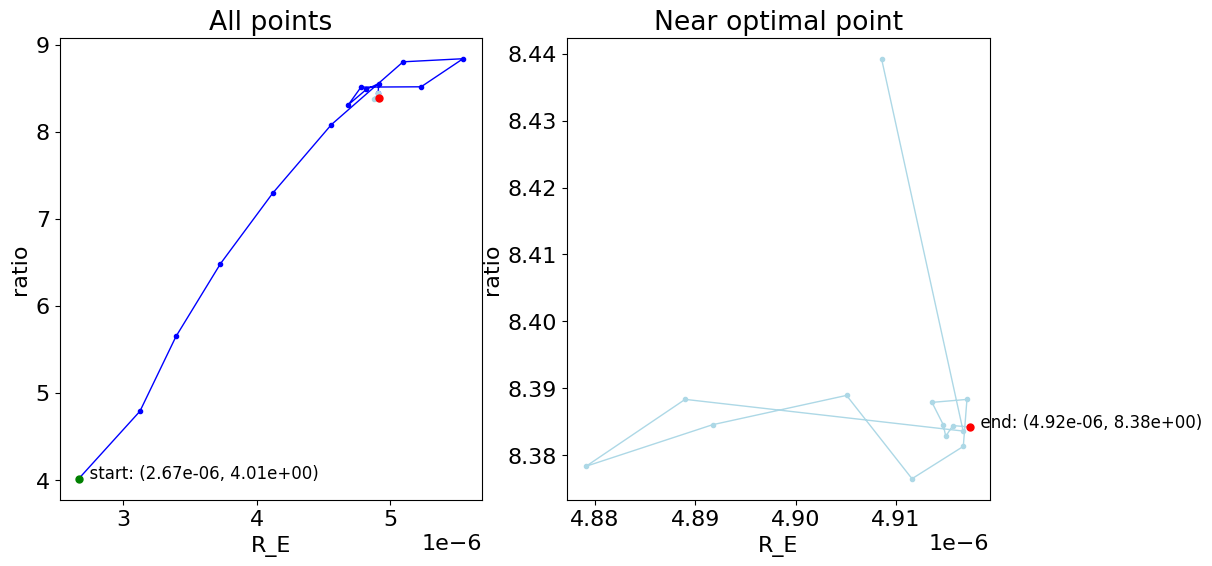

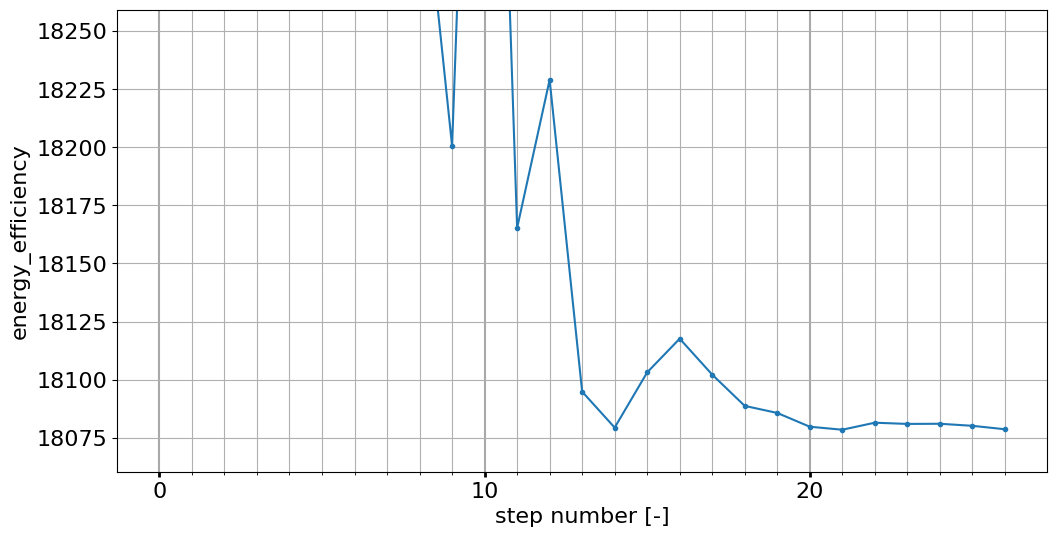

last output:  18078.65


In [34]:
all_central_points = []
central_outputs = []
for points in datas:
    outputs = [data[to_optimize] for data in points]
    central_outputs.append(outputs[0])
    #central_outputs.append(min(outputs))
    all_central_points.append(points[0])
value1 = [data[key1] for data in all_central_points]
value2 = [data[key2] for data in all_central_points]
start = len(all_central_points) // 2
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(value1[:start+1], value2[:start+1], '.-', color='blue', linewidth=1, zorder=1)
ax[0].plot(value1[start:], value2[start:], '.-', color='lightblue', linewidth=0.5, zorder=1)
ax[1].plot(value1[start:], value2[start:], '.-', color='lightblue', linewidth=1, zorder=1)
ax[0].scatter([value1[0]], [value2[0]], color='green', zorder=2, s=25)   # start point
ax[0].scatter([value1[-1]], [value2[-1]], color='red', zorder=2, s=25)   # optimal point
ax[1].scatter([value1[-1]], [value2[-1]], color='red', zorder=2, s=25)   # optimal point
ax[0].text(value1[0], value2[0], f'  start: ({value1[0]:.2e}, {value2[0]:.2e})', fontsize=12)
ax[1].text(value1[-1], value2[-1], f'  end: ({value1[-1]:.2e}, {value2[-1]:.2e})', fontsize=12)
ax[0].set_title('All points')
ax[1].set_title('Near optimal point')
ax[0].set_xlabel(key1)
ax[0].set_ylabel(key2)
ax[1].set_xlabel(key1)
ax[1].set_ylabel(key2)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(range(len(central_outputs[:])), central_outputs[:], '.-')
ax.set_ylim([0.999*min(central_outputs), 1.01*min(central_outputs)])
ax.set_xticks(range(0, len(central_outputs[:]), 10), minor=False)
ax.set_xticks(range(len(central_outputs[:])), minor=True)
ax.tick_params(which='major', axis='x', width=2, grid_color='darkgrey', grid_linewidth=1.5)
ax.set_xlabel('step number [-]')
ax.set_ylabel(to_optimize)
ax.grid(which='both')
#plt.yscale('log')
plt.show()
print(f'last output: {central_outputs[-1]: .2f}')

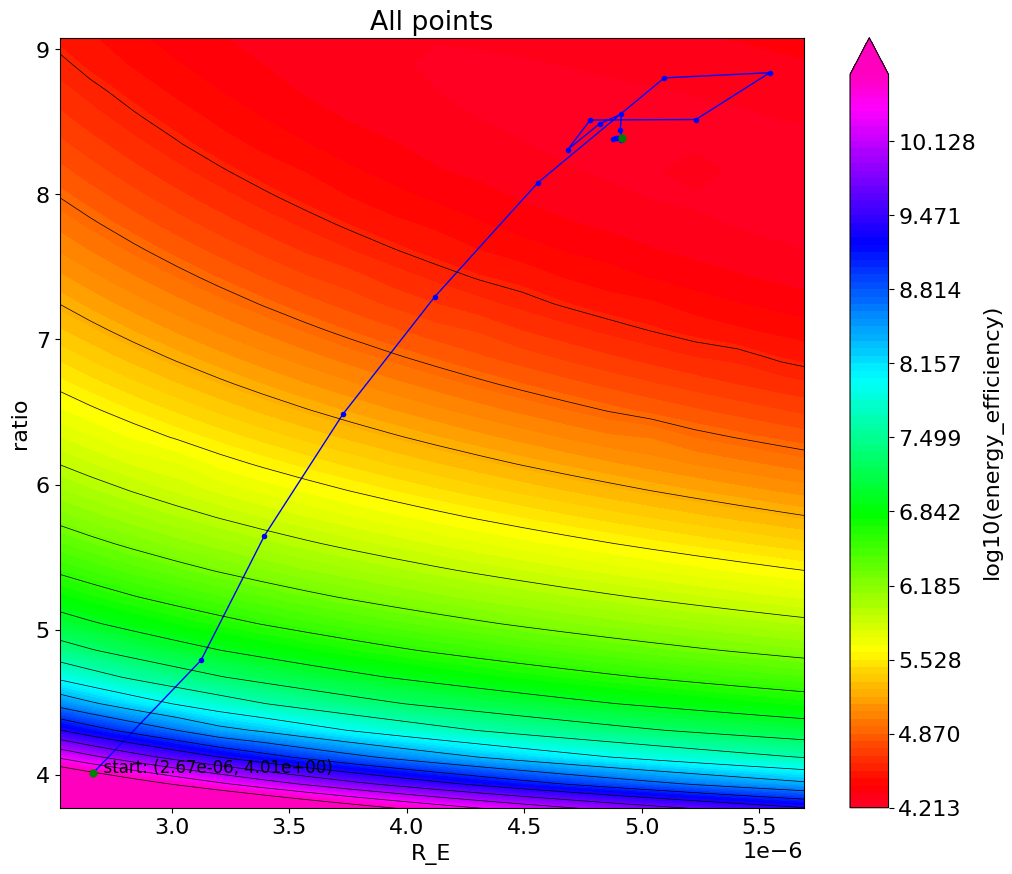

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
levels = np.linspace(vmin, vmax, 250)
maxi = np.log10(max(central_outputs))
cp = ax.contourf(X, Y, Z, levels=np.linspace(vmin, maxi, 100), cmap='gist_rainbow', vmax=maxi, extend='max')
ax.contour(X, Y, Z, levels=np.linspace(vmin, maxi, 20), colors='black', linewidths=0.5)
fig.colorbar(cp, label='log10(energy_efficiency)') # Add a colorbar to a plot

ax.plot(value1[:], value2[:], '.-', color='blue', linewidth=1, zorder=1)
ax.scatter([value1[0]], [value2[0]], color='green', zorder=2, s=25)   # start point
ax.scatter([value1[-1]], [value2[-1]], color='green', zorder=2, s=25)   # optimal point
ax.text(value1[0], value2[0], f'  start: ({value1[0]:.2e}, {value2[0]:.2e})', fontsize=12)
ax.set_title('All points')
ax.set_xlabel(key1)
ax.set_ylabel(key2)

range1 = max(value1) - min(value1)
range2 = max(value2) - min(value2)
range1 = [min(value1) - 0.05*range1, max(value1) + 0.05*range1]
range2 = [min(value2) - 0.05*range2, max(value2) + 0.05*range2]
ax.set_xlim(range1)
ax.set_ylim(range2)

plt.show()